<a href="https://colab.research.google.com/github/leandrobrana/Data-Science-II/blob/main/ProyectoDS2Parte1Bra%C3%B1a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análisis del comportamiento de la demanda eléctrica en el Sistema Argentino de Interconexión (SADI)**

El análisis del comportamiento de la demanda eléctrica, la potencia pico y las variables climáticas en el Sistema Argentino de Interconexión (SADI) resulta fundamental para comprender cómo opera el sistema energético frente a variaciones estacionales, térmicas y sociales. La disponibilidad de datos históricos detallados —que incluyen demanda total y regional, temperaturas medias por área, tipo de día y potencia pico— permite estudiar de manera profunda las dinámicas que determinan la carga eléctrica diaria del país.

Este proyecto se motiva en una necesidad real: el sistema eléctrico argentino se encuentra cada vez más exigido por eventos climáticos extremos, patrones de consumo cambiantes y urbanización acelerada. Entender cómo se comporta la demanda y qué factores explican los picos máximos es crítico para la planificación operativa, la gestión del riesgo, la inversión en infraestructura y el diseño de políticas energéticas basadas en evidencia.

La audiencia que puede beneficiarse de este análisis incluye:

Operadores del sistema eléctrico (como CAMMESA), que requieren estimaciones confiables de demanda y potencia pico para asegurar la estabilidad del sistema.

Ingenieros y analistas energéticos, interesados en desarrollar modelos predictivos y evaluar escenarios futuros.

Áreas de planificación y regulación, que necesitan comprender patrones estacionales y regionales para definir estrategias de expansión, eficiencia y resiliencia.

Equipos de ciencia de datos, que ven en esta base un caso sólido para aplicar técnicas de machine learning, imputación de datos faltantes, modelado predictivo y análisis multivariante.

El objetivo final es descubrir patrones, explicar comportamientos y construir modelos que permitan anticipar la demanda y los picos de potencia, maximizando la confiabilidad del sistema y facilitando la toma de decisiones en un contexto energético cada vez más desafiante.


# **Preguntas de investigación**

1 - ¿La demanda total del SADI aumenta significativamente cuando la temperatura media supera cierto umbral (olas de calor/frío)?

2 - ¿Qué regiones aportan mayor variabilidad diaria a la demanda total y cuáles son más sensibles a la temperatura?

3 - ¿Cómo se comporta la potencia pico en relación con la demanda total?

4 - ¿Hay alguna tendencia creciente o decreciente de la demanda a lo largo de los años?

5 - ¿Qué regiones muestran mayor variabilidad de demanda entre días laborables y fines de semana?

# **Instalaciones**

In [2]:
!pip install unidecode
!pip install missingno

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 4.3 MB/s eta 0:00:00


# **Import de librerias**

In [3]:
import requests
import pandas as pd
import os
from unidecode import unidecode
from functools import reduce
import ipywidgets as widgets
from IPython.display import display
from google.colab import files
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

# **Configuración de variables globales**

In [4]:
# Fechas de inicio y fin utilizadas para el filtrado del dataset y la consulta a la API histórica de clima.
start_date = "2017-01-01"
end_date = "2025-12-31"

In [5]:
# Se define array regiones, el cual va hacer utilizado en análisis posteriores
columnas_regiones = ['GRAN BS.AS.', 'BUENOS AIRES', 'CENTRO', 'LITORAL','CUYO', 'NORESTE', 'NOROESTE', 'COMAHUE', 'PATAGONICA']

In [6]:
# Se definen umbrales de temperaturas máximas y mínimas para futuros análisis
umbral_calor = 25   # Umbral de ola de calor
umbral_frio = 15    # Umbral de ola de frío

# **Carga de datasets. Limpieza y transformación de datos**

In [7]:
# Habilita la carga del dataset "Demanda Diaria MEM" desde el entorno local.
from google.colab import files
uploaded = files.upload()

Saving Demanda Diaria MEM.xlsx to Demanda Diaria MEM.xlsx


In [8]:
# Se extrae la hoja de interés para el presente análisis.
df_demanda = pd.read_excel("Demanda Diaria MEM.xlsx", sheet_name="Datos Región", skiprows=4)
# Se elimina la siguiente columna, ya que se utilizarán temperaturas de referencia por región.
df_demanda = df_demanda.drop(columns=["TEMPERATURA REFERENCIA MEDIA GBA °C"])
# Se eliminan caracteres especiales y se unifican los encabezados.
df_demanda.columns = [unidecode(col)        # Quita acentos
              .strip()                      # Quita espacios alrededor
              .upper()                      # Mayúsculas
              for col in df_demanda.columns]
# Se genera una nueva columna a partir de otras variables.
df_demanda['ESTACION'] = df_demanda['FECHA'].dt.month % 12 // 3 + 1
estaciones = {1: 'Verano', 2: 'Otoño', 3: 'Invierno', 4: 'Primavera'}
df_demanda['ESTACION'] = df_demanda['ESTACION'].map(estaciones)
# Se convierten las columnas de tipo object a tipo string.
df_demanda["TIPO DIA"] = df_demanda["TIPO DIA"].astype("string")
df_demanda["ESTACION"] = df_demanda["ESTACION"].astype("string")
# Se redondean a dos decimales todas las variables numéricas del dataset.
df_demanda = df_demanda.round(2)
# Se verifica que el dataset se procesó correctamente.
print("Dimensión:", df_demanda.shape)
display(df_demanda.head())
df_demanda.info()
display(df_demanda.isnull().sum())

Dimensión: (3287, 15)


,ANO,MES,FECHA,TIPO DIA,GRAN BS.AS.,BUENOS AIRES,CENTRO,LITORAL,CUYO,NOROESTE,NORESTE,COMAHUE,PATAGONICA,DEMANDA TOTAL,ESTACION
0,2017,2017-01-01,2017-01-01,Domingo o Feriado,6352.70,1472.27,1134.39,1766.62,903.14,1602.13,1400.33,561.24,500.86,15693.69,Verano
1,2017,2017-01-01,2017-01-02,Lunes habiles,6617.86,1779.44,1363.53,1963.93,1091.81,1627.57,1585.62,638.84,540.58,17209.16,Verano
2,2017,2017-01-01,2017-01-03,Martes Habiles,6678.00,1888.98,1600.74,2036.35,1178.72,1806.47,1652.99,624.65,536.47,18003.37,Verano
3,2017,2017-01-01,2017-01-04,Miercoles habiles,6427.00,1840.62,1356.38,1756.64,1078.90,1759.86,1604.75,598.40,528.90,16951.46,Verano
4,2017,2017-01-01,2017-01-05,Jueves Habiles,5873.95,1770.94,1366.02,1848.41,1037.79,1403.49,1228.30,585.21,524.66,15638.77,Verano


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ANO            3287 non-null   int64         
 1   MES            3287 non-null   datetime64[ns]
 2   FECHA          3287 non-null   datetime64[ns]
 3   TIPO DIA       3287 non-null   string        
 4   GRAN BS.AS.    3287 non-null   float64       
 5   BUENOS AIRES   3287 non-null   float64       
 6   CENTRO         3287 non-null   float64       
 7   LITORAL        3287 non-null   float64       
 8   CUYO           3287 non-null   float64       
 9   NOROESTE       3287 non-null   float64       
 10  NORESTE        3287 non-null   float64       
 11  COMAHUE        3287 non-null   float64       
 12  PATAGONICA     3287 non-null   float64       
 13  DEMANDA TOTAL  3287 non-null   float64       
 14  ESTACION       3287 non-null   string        
dtypes: datetime64[ns](2),

,0
ANO,0
MES,0
FECHA,0
TIPO DIA,0
GRAN BS.AS.,0
BUENOS AIRES,0
CENTRO,0
LITORAL,0
CUYO,0
NOROESTE,0


In [9]:
# Habilita la carga del dataset "Históricos valores de energía y Potencia" desde el entorno local.
from google.colab import files
uploaded = files.upload()

Saving Históricos valores de energía y Potencia.xlsx to Históricos valores de energía y Potencia.xlsx


In [10]:
# Se extrae la hoja de interés para el presente análisis.
df_generacion = pd.read_excel("Históricos valores de energía y Potencia.xlsx", sheet_name="Históricos Energía y Potencia", skiprows=5)
# Se extraen las columnas de interes.
df_generacion = df_generacion[["FECHA", "Potencia Pico SADI (MW)", "Hora Potencia Pico"]]
# Se eliminan caracteres especiales y se unifican los encabezados.
df_generacion.columns = [unidecode(col)               # Quita acentos
              .strip()                                # Quita espacios alrededor
              .upper()                                # Mayúsculas
              for col in df_generacion.columns]
# Se aplica un filtro de fecha para acotar los datos del segundo dataset.
df_generacion = df_generacion[(df_generacion["FECHA"] >= start_date) & (df_generacion["FECHA"] <= end_date)]
# Se redondean a dos decimales todas las variables numéricas del dataset.
df_generacion = df_generacion.round(2)
# Se verifica que el dataset se procesó correctamente.
print("Dimensión:", df_generacion.shape)
display(df_generacion.head())
df_generacion.info()
display(df_generacion.isnull().sum())

Dimensión: (3134, 3)


,FECHA,POTENCIA PICO SADI (MW),HORA POTENCIA PICO
3653,2017-01-01,19275.0,21.45
3654,2017-01-02,21847.0,21.49
3655,2017-01-03,21236.0,21.27
3656,2017-01-04,20340.0,21.37
3657,2017-01-05,19083.0,21.38


<class 'pandas.core.frame.DataFrame'>
Index: 3134 entries, 3653 to 6786
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   FECHA                    3134 non-null   datetime64[ns]
 1   POTENCIA PICO SADI (MW)  3134 non-null   float64       
 2   HORA POTENCIA PICO       3134 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 97.9 KB


,0
FECHA,0
POTENCIA PICO SADI (MW),0
HORA POTENCIA PICO,0


In [11]:
# Se realiza el merge entre ambos datasets utilizando la columna "FECHA" como clave.
df_merge = pd.merge(df_demanda, df_generacion, on="FECHA", how="outer")
# Se verifica que los datasets se unieron correctamente
print("Dimensión:", df_merge.shape)
display(df_merge.head())
df_merge.info()
display(df_merge.isnull().sum())

Dimensión: (3287, 17)


,ANO,MES,FECHA,TIPO DIA,GRAN BS.AS.,BUENOS AIRES,CENTRO,LITORAL,CUYO,NOROESTE,NORESTE,COMAHUE,PATAGONICA,DEMANDA TOTAL,ESTACION,POTENCIA PICO SADI (MW),HORA POTENCIA PICO
0,2017,2017-01-01,2017-01-01,Domingo o Feriado,6352.70,1472.27,1134.39,1766.62,903.14,1602.13,1400.33,561.24,500.86,15693.69,Verano,19275.0,21.45
1,2017,2017-01-01,2017-01-02,Lunes habiles,6617.86,1779.44,1363.53,1963.93,1091.81,1627.57,1585.62,638.84,540.58,17209.16,Verano,21847.0,21.49
2,2017,2017-01-01,2017-01-03,Martes Habiles,6678.00,1888.98,1600.74,2036.35,1178.72,1806.47,1652.99,624.65,536.47,18003.37,Verano,21236.0,21.27
3,2017,2017-01-01,2017-01-04,Miercoles habiles,6427.00,1840.62,1356.38,1756.64,1078.90,1759.86,1604.75,598.40,528.90,16951.46,Verano,20340.0,21.37
4,2017,2017-01-01,2017-01-05,Jueves Habiles,5873.95,1770.94,1366.02,1848.41,1037.79,1403.49,1228.30,585.21,524.66,15638.77,Verano,19083.0,21.38


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ANO                      3287 non-null   int64         
 1   MES                      3287 non-null   datetime64[ns]
 2   FECHA                    3287 non-null   datetime64[ns]
 3   TIPO DIA                 3287 non-null   string        
 4   GRAN BS.AS.              3287 non-null   float64       
 5   BUENOS AIRES             3287 non-null   float64       
 6   CENTRO                   3287 non-null   float64       
 7   LITORAL                  3287 non-null   float64       
 8   CUYO                     3287 non-null   float64       
 9   NOROESTE                 3287 non-null   float64       
 10  NORESTE                  3287 non-null   float64       
 11  COMAHUE                  3287 non-null   float64       
 12  PATAGONICA               3287 non-

,0
ANO,0
MES,0
FECHA,0
TIPO DIA,0
GRAN BS.AS.,0
BUENOS AIRES,0
CENTRO,0
LITORAL,0
CUYO,0
NOROESTE,0


In [12]:
# Se utiliza una API para obtener datos históricos de temperatura por región.

# Se define el arreglo de regiones y coordenadas.
regiones = {
    "GRAN BS.AS.": (-34.61, -58.38),
    "BUENOS AIRES": (-34.92, -57.95),
    "CENTRO": (-31.42, -64.18),
    "LITORAL": (-32.95, -60.66),
    "CUYO": (-32.89, -68.84),
    "NOROESTE": (-24.78, -65.41),
    "NORESTE": (-27.45, -58.99),
    "COMAHUE": (-38.95, -68.06),
    "PATAGONICA": (-45.87, -67.48)
}

url = "https://archive-api.open-meteo.com/v1/archive"
df_temperaturas = pd.DataFrame()
for region, (lat, lon) in regiones.items():

    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,
        "end_date": end_date,
        "daily": "temperature_2m_mean",
        "timezone": "America/Argentina/Buenos_Aires"
    }

    response = requests.get(url, params=params, timeout=30)
    response.raise_for_status()
    data = response.json()

    df_region = pd.DataFrame({
        "FECHA": data["daily"]["time"],
        region: data["daily"]["temperature_2m_mean"]
    })

    if df_temperaturas.empty:
        df_temperaturas = df_region
    else:
        df_temperaturas = df_temperaturas.merge(df_region, on="FECHA")

df_temperaturas["FECHA"] = pd.to_datetime(df_temperaturas["FECHA"])
df_temperaturas = df_temperaturas.rename(
    columns={region: f"TEMPERATURA MEDIA {region}" for region in regiones.keys()}
)

# Se verifica que el dataset se procesó correctamente.
print("Dimensión:", df_temperaturas.shape)
display(df_temperaturas.head())
df_temperaturas.info()
display(df_temperaturas.isnull().sum())

Dimensión: (3287, 10)


,FECHA,TEMPERATURA MEDIA GRAN BS.AS.,TEMPERATURA MEDIA BUENOS AIRES,TEMPERATURA MEDIA CENTRO,TEMPERATURA MEDIA LITORAL,TEMPERATURA MEDIA CUYO,TEMPERATURA MEDIA NOROESTE,TEMPERATURA MEDIA NORESTE,TEMPERATURA MEDIA COMAHUE,TEMPERATURA MEDIA PATAGONICA
0,2017-01-01,27.5,26.8,25.2,26.4,26.4,24.4,30.3,22.1,20.1
1,2017-01-02,24.3,23.4,24.4,25.0,26.6,24.0,29.9,23.9,19.0
2,2017-01-03,25.4,25.0,28.1,24.3,28.3,24.3,30.4,20.4,15.9
3,2017-01-04,24.8,24.3,23.1,24.7,23.6,23.2,29.4,18.7,12.5
4,2017-01-05,22.6,21.4,23.1,23.3,23.6,20.2,26.2,18.9,14.9


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   FECHA                           3287 non-null   datetime64[ns]
 1   TEMPERATURA MEDIA GRAN BS.AS.   3287 non-null   float64       
 2   TEMPERATURA MEDIA BUENOS AIRES  3287 non-null   float64       
 3   TEMPERATURA MEDIA CENTRO        3287 non-null   float64       
 4   TEMPERATURA MEDIA LITORAL       3287 non-null   float64       
 5   TEMPERATURA MEDIA CUYO          3287 non-null   float64       
 6   TEMPERATURA MEDIA NOROESTE      3287 non-null   float64       
 7   TEMPERATURA MEDIA NORESTE       3287 non-null   float64       
 8   TEMPERATURA MEDIA COMAHUE       3287 non-null   float64       
 9   TEMPERATURA MEDIA PATAGONICA    3287 non-null   float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 256.9 KB


,0
FECHA,0
TEMPERATURA MEDIA GRAN BS.AS.,0
TEMPERATURA MEDIA BUENOS AIRES,0
TEMPERATURA MEDIA CENTRO,0
TEMPERATURA MEDIA LITORAL,0
TEMPERATURA MEDIA CUYO,0
TEMPERATURA MEDIA NOROESTE,0
TEMPERATURA MEDIA NORESTE,0
TEMPERATURA MEDIA COMAHUE,0
TEMPERATURA MEDIA PATAGONICA,0


In [13]:
# Se realiza el merge entre ambos datasets utilizando la columna "FECHA" como clave.
df_final = pd.merge(df_merge, df_temperaturas, on="FECHA")

# Se reordena el DataFrame para ubicar la columna "FECHA" en la primera posición
cols = df_final.columns.tolist()
cols.insert(0, cols.pop(cols.index("FECHA")))
df_final = df_final[cols]

display(df_final.head(10))

,FECHA,ANO,MES,TIPO DIA,GRAN BS.AS.,BUENOS AIRES,CENTRO,LITORAL,CUYO,NOROESTE,...,HORA POTENCIA PICO,TEMPERATURA MEDIA GRAN BS.AS.,TEMPERATURA MEDIA BUENOS AIRES,TEMPERATURA MEDIA CENTRO,TEMPERATURA MEDIA LITORAL,TEMPERATURA MEDIA CUYO,TEMPERATURA MEDIA NOROESTE,TEMPERATURA MEDIA NORESTE,TEMPERATURA MEDIA COMAHUE,TEMPERATURA MEDIA PATAGONICA
0,2017-01-01,2017,2017-01-01,Domingo o Feriado,6352.70,1472.27,1134.39,1766.62,903.14,1602.13,...,21.45,27.5,26.8,25.2,26.4,26.4,24.4,30.3,22.1,20.1
1,2017-01-02,2017,2017-01-01,Lunes habiles,6617.86,1779.44,1363.53,1963.93,1091.81,1627.57,...,21.49,24.3,23.4,24.4,25.0,26.6,24.0,29.9,23.9,19.0
2,2017-01-03,2017,2017-01-01,Martes Habiles,6678.00,1888.98,1600.74,2036.35,1178.72,1806.47,...,21.27,25.4,25.0,28.1,24.3,28.3,24.3,30.4,20.4,15.9
3,2017-01-04,2017,2017-01-01,Miercoles habiles,6427.00,1840.62,1356.38,1756.64,1078.90,1759.86,...,21.37,24.8,24.3,23.1,24.7,23.6,23.2,29.4,18.7,12.5
4,2017-01-05,2017,2017-01-01,Jueves Habiles,5873.95,1770.94,1366.02,1848.41,1037.79,1403.49,...,21.38,22.6,21.4,23.1,23.3,23.6,20.2,26.2,18.9,14.9
5,2017-01-06,2017,2017-01-01,Viernes habiles,5781.11,1801.10,1367.35,1929.80,1135.51,1354.62,...,21.34,23.2,22.3,23.0,23.8,26.7,19.9,26.1,25.0,20.1
6,2017-01-07,2017,2017-01-01,Sabado o Semilaborable,6231.73,1862.75,1388.80,2042.92,1161.95,1425.69,...,21.21,27.0,26.2,26.3,27.1,28.3,21.7,26.7,24.8,18.7
7,2017-01-08,2017,2017-01-01,Domingo o Feriado,5188.79,1541.26,1177.85,1759.30,997.10,1504.23,...,22.15,24.8,24.5,23.6,24.8,26.5,23.5,29.7,24.5,19.1
8,2017-01-09,2017,2017-01-01,Lunes habiles,6257.52,1754.25,1355.71,1833.18,1192.79,1685.16,...,15.14,24.0,23.7,25.2,24.9,26.9,23.4,31.0,22.1,16.4
9,2017-01-10,2017,2017-01-01,Martes Habiles,5492.77,1709.05,1313.67,1745.42,1140.39,1289.83,...,21.02,21.2,20.8,22.4,21.8,24.5,19.1,25.9,19.7,17.8


## **Descarga del dataset**

In [ ]:
# Nombre del archivo
file_name = "dataset_final.xlsx"

# Guardar el DataFrame en Excel
df_final.to_excel(file_name, index=False)

# Crear botón
button = widgets.Button(
    description="Descargar dataset en Excel",
    button_style="success",
    icon="download"
)

# Acción del botón
def download_excel(b):
    files.download(file_name)

button.on_click(download_excel)

display(button)

Button(button_style='success', description='Descargar dataset en Excel', icon='download', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Análisis exploratorio de datos**

## **Informacion del dataset**

In [14]:
# Se obtiene la dimensión del dataset (filas, columnas).
df_final.shape

(3287, 26)

In [50]:
# Se visualiza un resumen de los tipos de datos del dataset.
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   FECHA                           3287 non-null   datetime64[ns]
 1   ANO                             3287 non-null   int64         
 2   MES                             3287 non-null   datetime64[ns]
 3   TIPO DIA                        3287 non-null   string        
 4   GRAN BS.AS.                     3287 non-null   float64       
 5   BUENOS AIRES                    3287 non-null   float64       
 6   CENTRO                          3287 non-null   float64       
 7   LITORAL                         3287 non-null   float64       
 8   CUYO                            3287 non-null   float64       
 9   NOROESTE                        3287 non-null   float64       
 10  NORESTE                         3287 non-null   float64       
 11  COMA

In [51]:
# Se calculan estadísticas descriptivas de las variables numéricas del dataset.
df_final.describe()

,FECHA,ANO,MES,GRAN BS.AS.,BUENOS AIRES,CENTRO,LITORAL,CUYO,NOROESTE,NORESTE,...,HORA POTENCIA PICO,TEMPERATURA MEDIA GRAN BS.AS.,TEMPERATURA MEDIA BUENOS AIRES,TEMPERATURA MEDIA CENTRO,TEMPERATURA MEDIA LITORAL,TEMPERATURA MEDIA CUYO,TEMPERATURA MEDIA NOROESTE,TEMPERATURA MEDIA NORESTE,TEMPERATURA MEDIA COMAHUE,TEMPERATURA MEDIA PATAGONICA
count,3287,3287.000000,3287,3287.000000,3287.000000,3287.000000,3287.000000,3287.000000,3287.000000,3287.000000,...,3134.000000,3287.000000,3287.000000,3287.000000,3287.000000,3287.000000,3287.000000,3287.000000,3287.000000,3287.000000
mean,2021-07-02 00:00:00,2021.000608,2021-06-17 06:30:46.547003136,5789.352227,1820.897019,1355.802735,1865.097441,940.785595,1283.826422,1137.233867,...,19.705243,17.695041,17.225616,17.998783,18.534500,17.305993,15.947612,22.162215,15.693307,13.168847
min,2017-01-01 00:00:00,2017.000000,2017-01-01 00:00:00,3764.620000,922.620000,818.020000,1196.950000,654.900000,664.080000,596.460000,...,9.410000,2.700000,2.300000,1.700000,2.000000,-2.400000,0.800000,6.200000,-2.200000,-0.200000
25%,2019-04-02 12:00:00,2019.000000,2019-04-01 00:00:00,5052.160000,1681.450000,1218.100000,1665.925000,848.085000,1110.950000,917.890000,...,20.150000,13.100000,12.900000,13.300000,13.800000,11.500000,12.400000,18.200000,9.500000,8.800000
50%,2021-07-02 00:00:00,2021.000000,2021-07-01 00:00:00,5573.150000,1817.320000,1332.700000,1815.710000,912.120000,1222.610000,1038.650000,...,20.430000,17.800000,17.400000,18.400000,18.800000,17.200000,16.700000,22.800000,15.500000,13.200000
75%,2023-10-01 12:00:00,2023.000000,2023-10-01 00:00:00,6476.395000,1952.340000,1479.910000,2036.830000,1005.290000,1413.105000,1324.005000,...,21.000000,22.200000,21.700000,22.800000,23.400000,23.200000,19.850000,26.400000,21.850000,17.500000
max,2025-12-31 00:00:00,2025.000000,2025-12-01 00:00:00,9366.820000,2507.400000,2277.470000,3166.510000,1510.410000,2231.400000,2100.470000,...,23.320000,33.100000,31.600000,33.800000,33.600000,33.500000,26.300000,36.600000,33.900000,30.500000
std,NaN,2.582185,NaN,1024.153324,210.438265,212.447411,317.237523,136.517423,236.850341,281.678537,...,2.130816,5.721499,5.580463,5.934281,5.910506,7.073748,4.915238,5.678908,7.406906,5.750525


## **Análisis de valores nulos**

In [49]:
# Cantidad de datos null
df_final.isnull().sum()

,0
FECHA,0
ANO,0
MES,0
TIPO DIA,0
GRAN BS.AS.,0
BUENOS AIRES,0
CENTRO,0
LITORAL,0
CUYO,0
NOROESTE,0


<Axes: >

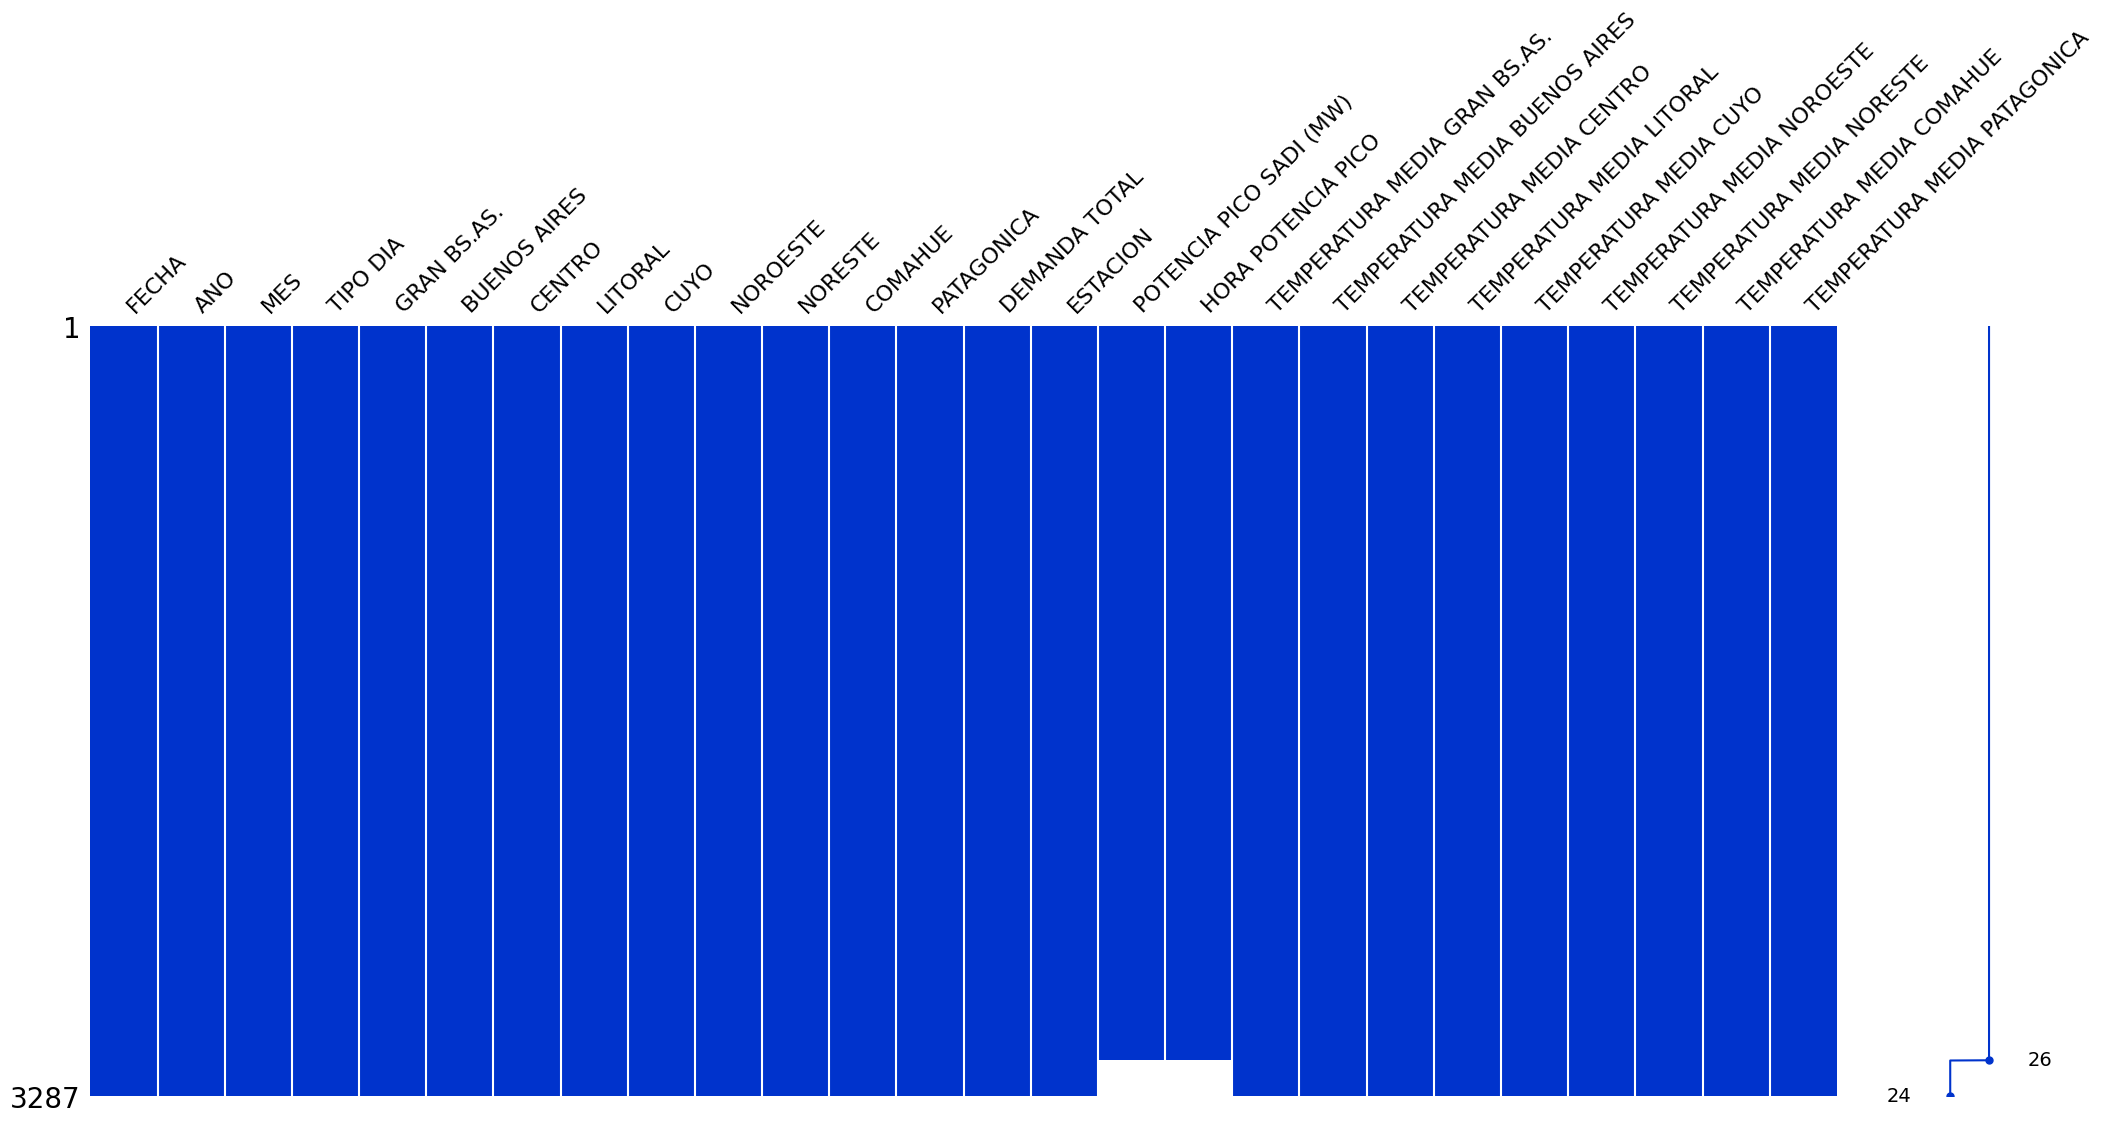

In [18]:
# Grafico de matriz de valores faltantes
msno.matrix(df_final, color=(0, 0.2, 0.8))

<Axes: >

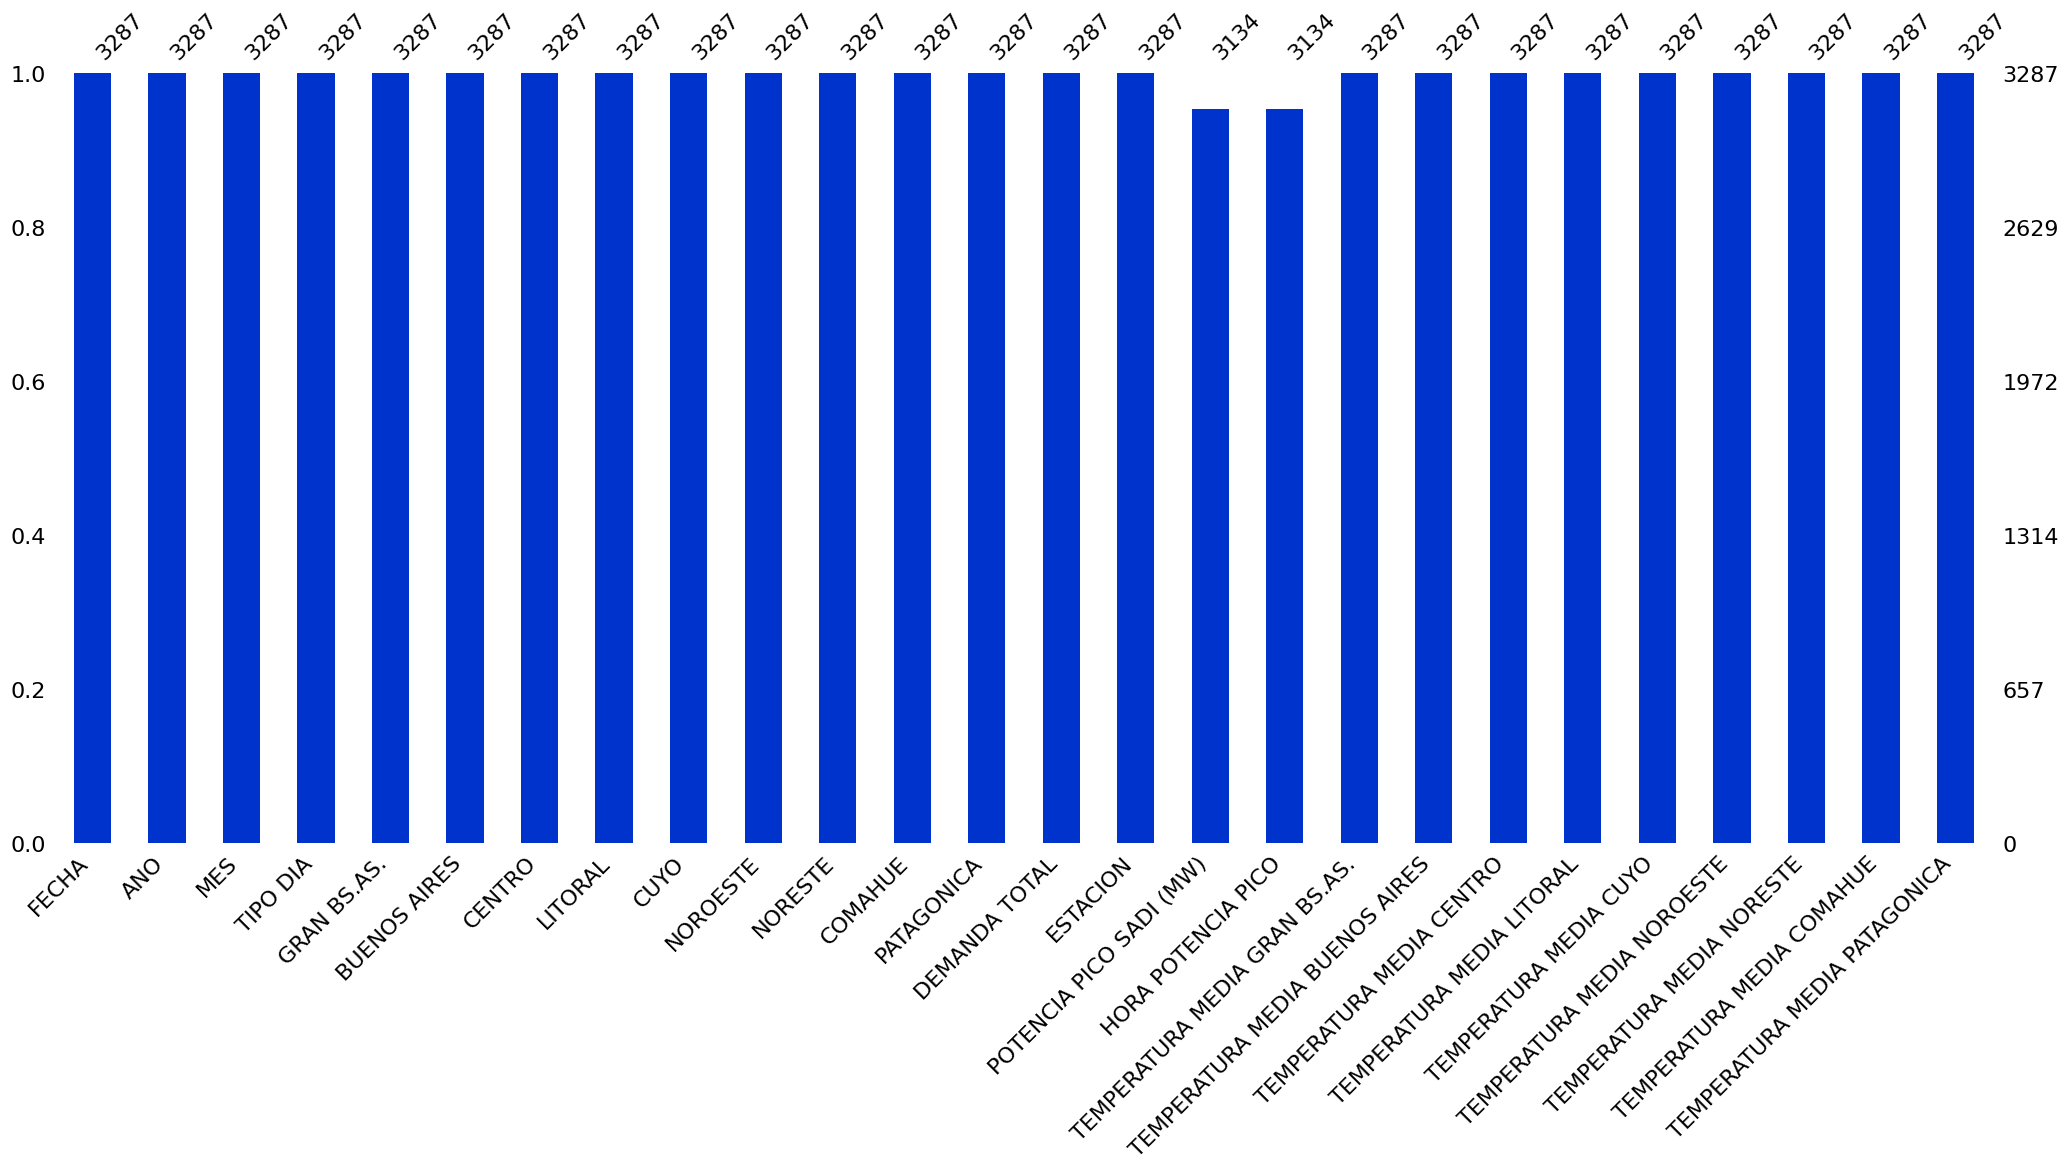

In [19]:
# Gráfico de barras de valores faltantes por columna
msno.bar(df_final, color=(0, 0.2, 0.8))

Se detectaron 153 valores faltantes en las variables “Potencia Pico SADI (MW)” y “Hora Potencia Pico”. La ausencia de estos registros se debe a información incompleta en el dataset Históricos valores de energía y Potencia.

Dado que estas variables no son centrales en el presente análisis, en esta primera etapa se opta por excluir dichos registros del estudio. En una instancia posterior se evaluará e implementará una estrategia metodológica adecuada para la imputación de estos valores faltantes.

## **Análisis de duplicados**

In [20]:
# Se obtienen las filas duplicadas
duplicados_completos = df_final[df_final.duplicated()]
print(f"Filas completamente duplicadas: {len(duplicados_completos)}")

Filas completamente duplicadas: 0


In [21]:
# Se obtienen las fechas duplicadas (independientemente de otras columnas)
duplicadas_fecha = df_final[df_final.duplicated(subset='FECHA')]
print(f"Fechas duplicadas: {len(duplicadas_fecha)}")

Fechas duplicadas: 0


## **Análisis de valores outliers**

Se encontraron 49 outliers en la demanda total.


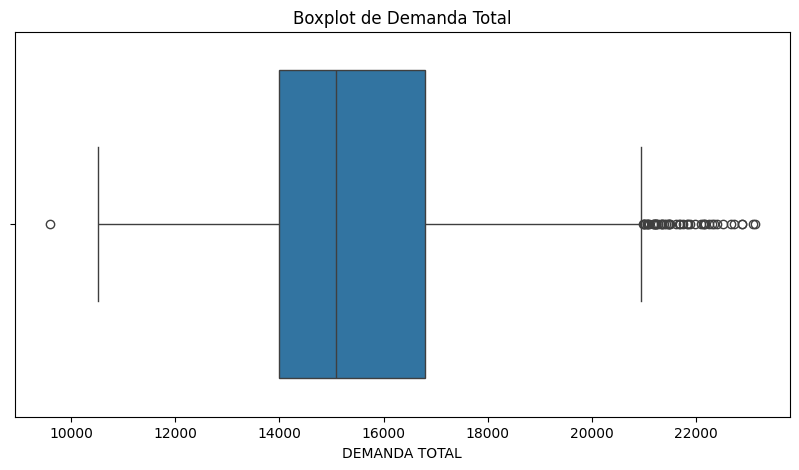

In [22]:
Q1 = df_final['DEMANDA TOTAL'].quantile(0.25)
Q3 = df_final['DEMANDA TOTAL'].quantile(0.75)
IQR = Q3 - Q1

# Limites
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrar outliers
outliers = df_final[(df_final['DEMANDA TOTAL'] < limite_inferior) | (df_final['DEMANDA TOTAL'] > limite_superior)]

print(f"Se encontraron {outliers.shape[0]} outliers en la demanda total.")

plt.figure(figsize=(10, 5))
sns.boxplot(x=df_final['DEMANDA TOTAL'])
plt.title('Boxplot de Demanda Total')
plt.show()

Se identificaron 49 valores atípicos en la demanda total, concentrados mayormente en el extremo superior de la distribución. Estos valores no parecen responder a errores de medición, sino a eventos de alta exigencia del sistema, probablemente asociados a condiciones climáticas extremas. Dado su relevancia operativa, se decidió mantenerlos en el análisis.

Se encontraron 59 outliers en la demanda total.


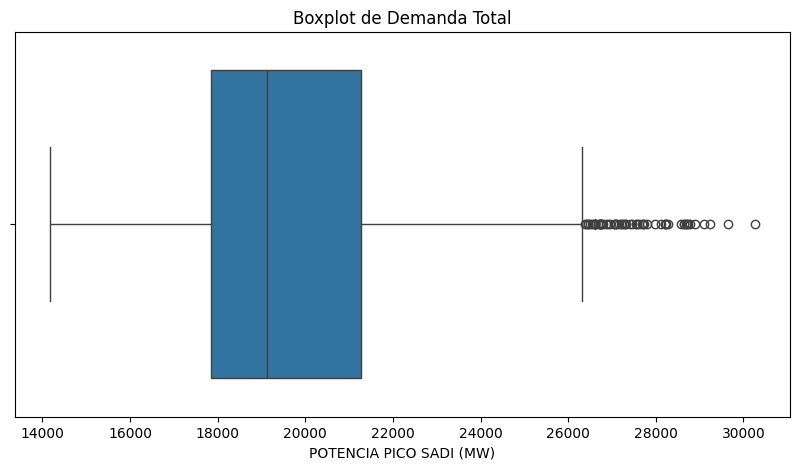

In [23]:
Q1 = df_final['POTENCIA PICO SADI (MW)'].quantile(0.25)
Q3 = df_final['POTENCIA PICO SADI (MW)'].quantile(0.75)
IQR = Q3 - Q1

# Limites
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrar outliers
outliers = df_final[(df_final['POTENCIA PICO SADI (MW)'] < limite_inferior) | (df_final['POTENCIA PICO SADI (MW)'] > limite_superior)]

print(f"Se encontraron {outliers.shape[0]} outliers en la demanda total.")

plt.figure(figsize=(10, 5))
sns.boxplot(x=df_final['POTENCIA PICO SADI (MW)'])
plt.title('Boxplot de Demanda Total')
plt.show()

Se identificaron 59 valores atípicos en la potencia pico del SADI, concentrados en el extremo superior de la distribución. Estos valores representan eventos de máxima exigencia del sistema, probablemente asociados a condiciones climáticas extremas. Lejos de considerarse errores, constituyen información crítica para el análisis de comportamiento y planificación del sistema eléctrico.

,REGION,CANTIDAD_OUTLIERS
8,PATAGONICA,272
4,CUYO,130
3,LITORAL,100
7,COMAHUE,91
6,NOROESTE,70
2,CENTRO,58
1,BUENOS AIRES,36
5,NORESTE,29
0,GRAN BS.AS.,18


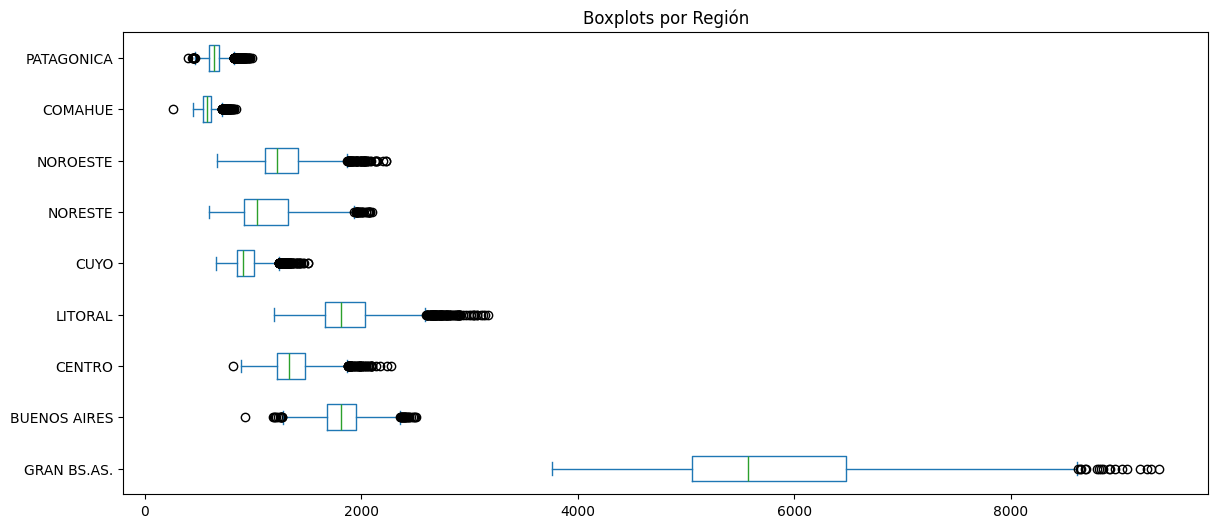

In [24]:
outliers_por_region = {}

for region in columnas_regiones:
    Q1 = df_final[region].quantile(0.25)
    Q3 = df_final[region].quantile(0.75)
    IQR = Q3 - Q1

    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    outliers = df_final[(df_final[region] < limite_inferior) | (df_final[region] > limite_superior)]

    outliers_por_region[region] = outliers.shape[0]

df_outliers = pd.DataFrame(list(outliers_por_region.items()), columns=['REGION', 'CANTIDAD_OUTLIERS'])
df_outliers = df_outliers.sort_values(by='CANTIDAD_OUTLIERS', ascending=False)
display(df_outliers)

df_final[columnas_regiones].plot(kind='box', figsize=(14, 6), vert=False)
plt.title('Boxplots por Región')
plt.show()

Se observa una concentración significativa de valores atípicos en regiones con mayor variabilidad térmica, especialmente Patagonia. Estos valores no parecen corresponder a errores de medición sino a eventos extremos de demanda, probablemente asociados a condiciones climáticas severas. Por lo tanto, se decide conservarlos para el análisis principal, dado que representan el comportamiento real del sistema eléctrico.

## **Análisis de la variable objetivo**

,DEMANDA TOTAL
count,3287.000000
mean,15424.430901
std,2121.487446
min,9594.110000
25%,13991.360000
50%,15084.350000
75%,16788.065000
max,23128.420000


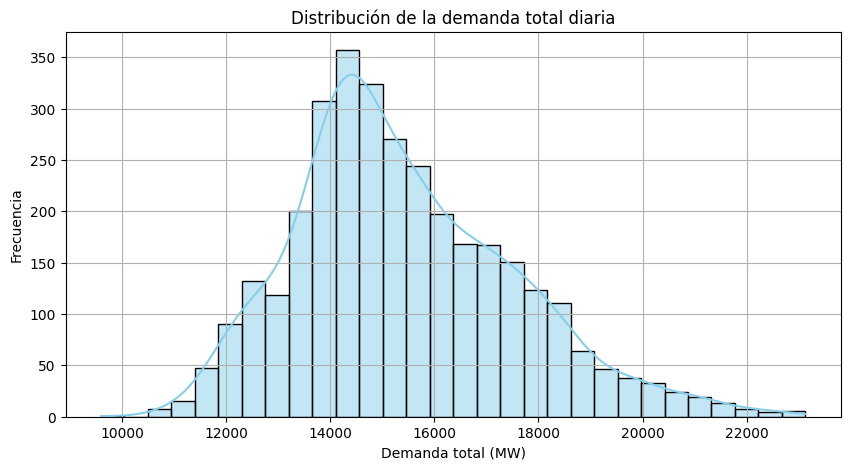

In [25]:
display(df_final['DEMANDA TOTAL'].describe())

# Histograma
plt.figure(figsize=(10, 5))
sns.histplot(df_final['DEMANDA TOTAL'], bins=30, kde=True, color='skyblue')
plt.title('Distribución de la demanda total diaria')
plt.xlabel('Demanda total (MW)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

**Forma de la distribución:**

Es asimétrica positiva (sesgada a la derecha).

La mayoría de los valores se concentran entre los 13.000 y 17.000 MW.

Hay una “cola” hacia valores mayores, lo que indica presencia de días con altas demandas excepcionales.

**Asimetría**

La cola derecha más larga indica que existen días de alta demanda extrema posiblemente asociados a:

 - Olas de calor

 - Olas de frío

 - Días hábiles en invierno/verano

**Moda:**

El pico de frecuencia está cerca de los 14.500 MW, lo que sería la moda: el valor más frecuente de demanda diaria.

**Valores extremos (outliers):**

Hay valores que superan los 22.000 MW, lo que puede asociarse a días de alto consumo energético, probablemente en verano (uso de aire acondicionado) o invierno (calefacción).

**Interpretación:**

El sistema eléctrico nacional opera la mayor parte del tiempo en un rango bastante estable.

La asimetría sugiere que los picos de demanda (eventos extremos) son menos frecuentes pero relevantes.

# **Análisis de las preguntas de investigación**

## ¿La demanda total del SADI aumenta significativamente cuando la temperatura media supera cierto umbral (olas de calor/frío)?

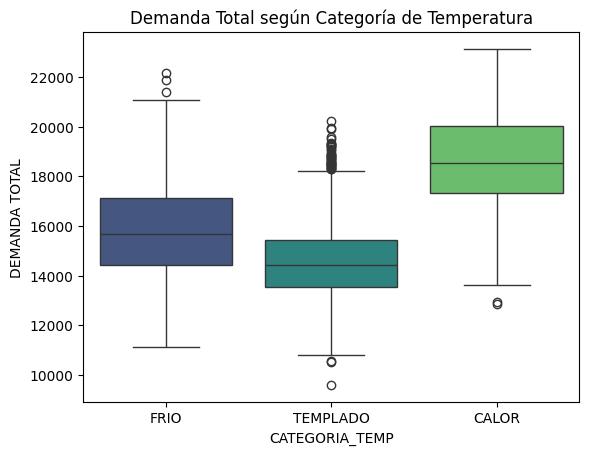

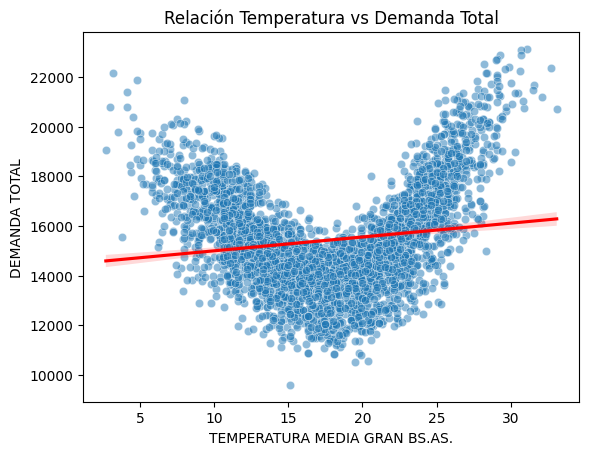

In [26]:

# Crear categoría según temperatura
df_final["CATEGORIA_TEMP"] = pd.cut(
    df_final["TEMPERATURA MEDIA GRAN BS.AS."],
    bins=[-50, umbral_frio, umbral_calor, 100],
    labels=["FRIO", "TEMPLADO", "CALOR"]
)

df_final.groupby("CATEGORIA_TEMP", observed=False)["DEMANDA TOTAL"].mean()

# Boxplot de demanda vs temperatura
sns.boxplot(
    data=df_final,
    x="CATEGORIA_TEMP",
    y="DEMANDA TOTAL",
    hue="CATEGORIA_TEMP",
    palette="viridis",
    legend=False
)

plt.title("Demanda Total según Categoría de Temperatura")
plt.show()

#Scatterplot para ver tendencia directa
sns.scatterplot(
    data=df_final,
    x="TEMPERATURA MEDIA GRAN BS.AS.",
    y="DEMANDA TOTAL",
    alpha=0.5
)
sns.regplot(
    data=df_final,
    x="TEMPERATURA MEDIA GRAN BS.AS.",
    y="DEMANDA TOTAL",
    scatter=False,
    color="red"
)
plt.title("Relación Temperatura vs Demanda Total")
plt.show()


El análisis evidencia un comportamiento no lineal entre temperatura media y demanda total del SADI. Se observa un mínimo de consumo en el rango templado, mientras que temperaturas extremas, tanto bajas como altas, generan incrementos significativos en la demanda. El efecto es particularmente marcado en condiciones de calor intenso, lo que sugiere una elevada sensibilidad del sistema ante olas de calor

## ¿Qué regiones aportan mayor variabilidad diaria a la demanda total y cuáles son más sensibles a la temperatura?

Variabilidad diaria por región (ordenado por CV): 

         REGION          STD         MEAN        CV
6      NOROESTE   281.678537  1137.233867  0.247687
5       NORESTE   236.850341  1283.826422  0.184488
0   GRAN BS.AS.  1024.153324  5789.352227  0.176903
3       LITORAL   317.237523  1865.097441  0.170092
2        CENTRO   212.447411  1355.802735  0.156695
4          CUYO   136.517423   940.785595  0.145110
8    PATAGONICA    89.042356   653.850834  0.136181
1  BUENOS AIRES   210.438265  1820.897019  0.115568
7       COMAHUE    57.803548   577.584606  0.100078

Sensibilidad térmica por región (correlación): 

         REGION  CORR_TEMP
5       NORESTE   0.740458
4          CUYO   0.482840
6      NOROESTE   0.474596
3       LITORAL   0.326337
7       COMAHUE   0.200327
2        CENTRO   0.099929
1  BUENOS AIRES  -0.030727
0   GRAN BS.AS.  -0.169440
8    PATAGONICA  -0.301679

Conclusiones

- Región con MAYOR variabilidad diaria: NOROESTE
- Región con MENOR variabilidad diaria: COMA

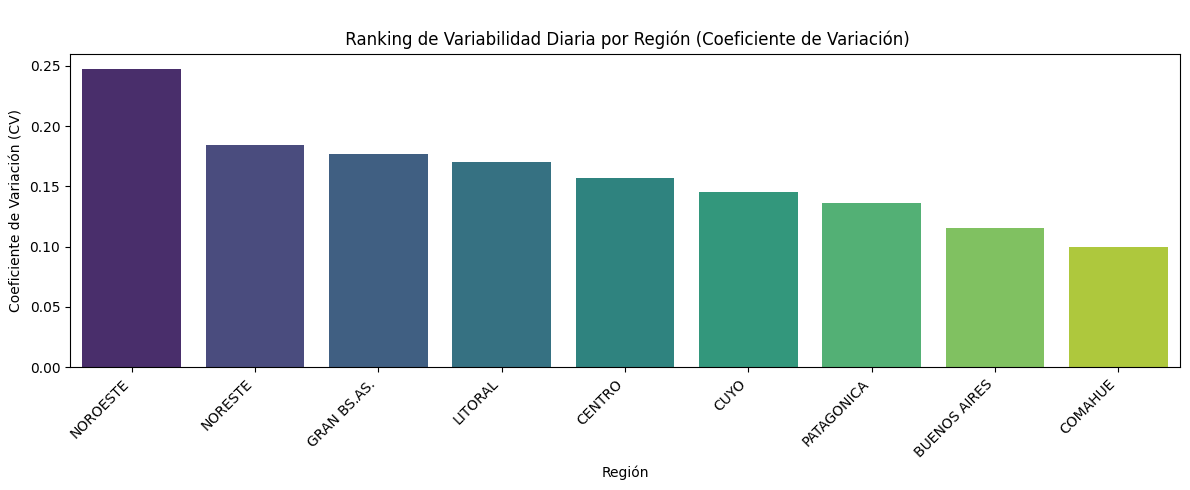

In [27]:
variabilidad = pd.DataFrame({
    "REGION": columnas_regiones,
    "STD": [df_final[r].std() for r in regiones],
    "MEAN": [df_final[r].mean() for r in regiones]
})

variabilidad["CV"] = variabilidad["STD"] / variabilidad["MEAN"]
variabilidad = variabilidad.sort_values("CV", ascending=False)

print("Variabilidad diaria por región (ordenado por CV): \n")
print(variabilidad)


temp_cols = {
    "GRAN BS.AS.": "TEMPERATURA MEDIA GRAN BS.AS.",
    "BUENOS AIRES": "TEMPERATURA MEDIA BUENOS AIRES",
    "CENTRO": "TEMPERATURA MEDIA CENTRO",
    "LITORAL": "TEMPERATURA MEDIA LITORAL",
    "CUYO": "TEMPERATURA MEDIA CUYO",
    "NOROESTE": "TEMPERATURA MEDIA NOROESTE",
    "NORESTE": "TEMPERATURA MEDIA NORESTE",
    "COMAHUE": "TEMPERATURA MEDIA COMAHUE",
    "PATAGONICA": "TEMPERATURA MEDIA PATAGONICA",
}


sensibilidad = []

for region in columnas_regiones:
    temp_col = temp_cols[region]
    corr = df_final[[region, temp_col]].corr().iloc[0,1]
    sensibilidad.append((region, corr))

sensibilidad_df = pd.DataFrame(sensibilidad, columns=["REGION", "CORR_TEMP"])
sensibilidad_df = sensibilidad_df.sort_values("CORR_TEMP", ascending=False)

print("\nSensibilidad térmica por región (correlación): \n")
print(sensibilidad_df)


print("\nConclusiones\n")

region_mas_variable = variabilidad.iloc[0]["REGION"]
region_menos_variable = variabilidad.iloc[-1]["REGION"]

region_mas_sensible = sensibilidad_df.iloc[0]["REGION"]
region_menos_sensible = sensibilidad_df.iloc[-1]["REGION"]

print(f"- Región con MAYOR variabilidad diaria: {region_mas_variable}")
print(f"- Región con MENOR variabilidad diaria: {region_menos_variable}")
print(f"- Región MÁS sensible al clima (temperatura): {region_mas_sensible}")
print(f"- Región MENOS sensible al clima (temperatura): {region_menos_sensible}")

plt.figure(figsize=(12,5))
sns.barplot(
    data=variabilidad,
    x="REGION",
    y="CV",
    hue="REGION",       # requerido por seaborn
    palette="viridis",
    dodge=False,        # para que no repita barras
    legend=False        # para evitar leyenda duplicada
)
plt.xticks(rotation=45, ha="right")
plt.title("\n Ranking de Variabilidad Diaria por Región (Coeficiente de Variación)")
plt.ylabel("Coeficiente de Variación (CV)")
plt.xlabel("Región")
plt.tight_layout()
plt.show()




El análisis del coeficiente de variación evidencia que la región Noroeste presenta la mayor volatilidad diaria relativa, lo que sugiere una elevada sensibilidad ante cambios en las condiciones climáticas. En contraste, regiones como Comahue y Buenos Aires muestran perfiles más estables. La mayor variabilidad observada en Noroeste y Noreste podría estar asociada a una mayor dependencia de climatización eléctrica y a mayores amplitudes térmicas, lo que incrementa la elasticidad de la demanda frente a cambios de temperatura.

## ¿Cómo se comporta la potencia pico en relación con la demanda total?

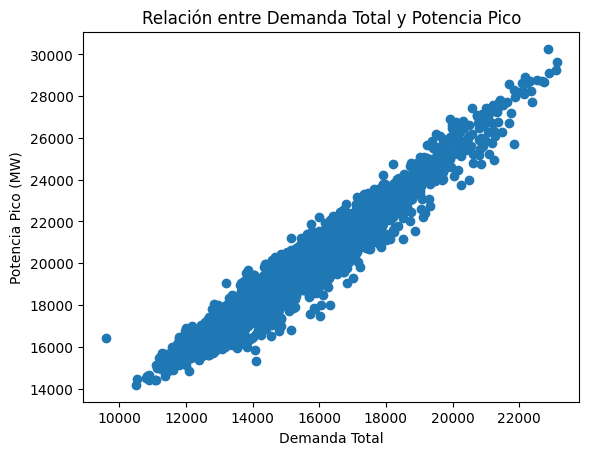

                               OLS Regression Results                              
Dep. Variable:     POTENCIA PICO SADI (MW)   R-squared:                       0.944
Model:                                 OLS   Adj. R-squared:                  0.944
Method:                      Least Squares   F-statistic:                 5.245e+04
Date:                     Fri, 13 Feb 2026   Prob (F-statistic):               0.00
Time:                             21:12:36   Log-Likelihood:                -24595.
No. Observations:                     3134   AIC:                         4.919e+04
Df Residuals:                         3132   BIC:                         4.921e+04
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [42]:
plt.scatter(df_final["DEMANDA TOTAL"], df_final["POTENCIA PICO SADI (MW)"])
plt.xlabel("Demanda Total")
plt.ylabel("Potencia Pico (MW)")
plt.title("Relación entre Demanda Total y Potencia Pico")
plt.show()

df_final["DEMANDA TOTAL"].corr(df_final["POTENCIA PICO SADI (MW)"])



df_final[["DEMANDA TOTAL", "POTENCIA PICO SADI (MW)"]].isna().sum()

df_model = df_final[["DEMANDA TOTAL", "POTENCIA PICO SADI (MW)"]].dropna()

import statsmodels.api as sm

X = sm.add_constant(df_model["DEMANDA TOTAL"])
y = df_model["POTENCIA PICO SADI (MW)"]

modelo = sm.OLS(y, X).fit()
print(modelo.summary())


Existe una relación lineal positiva muy fuerte entre ambas variables. La demanda total explica aproximadamente el 94% de la variabilidad de la potencia pico diaria, lo que indica que el nivel máximo del sistema está estrechamente vinculado al volumen agregado de consumo energético.

## ¿Hay alguna tendencia creciente o decreciente de la demanda a lo largo de los años?

,DEMANDA TOTAL
ANO,
2017,15129.020438
2018,15183.781178
2019,14719.869562
2020,14493.048579
2021,15282.818137
2022,15841.921589
2023,16082.595589
2024,15963.046503
2025,16124.852603


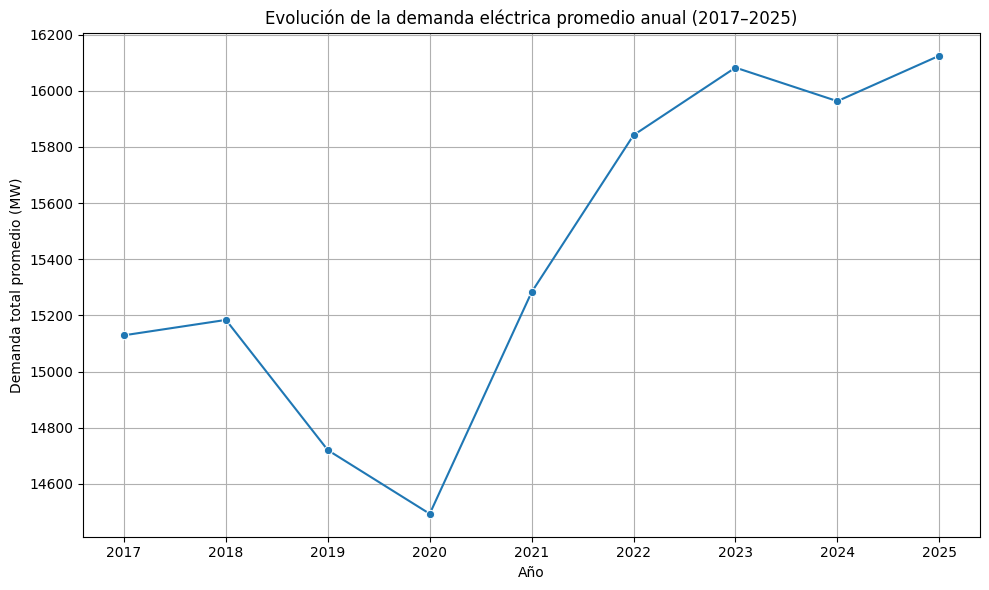

In [43]:
demanda_anual = df_final.groupby('ANO')['DEMANDA TOTAL'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=demanda_anual.index, y=demanda_anual.values, marker='o')
plt.title('Evolución de la demanda eléctrica promedio anual (2017–2025)')
plt.xlabel('Año')
plt.ylabel('Demanda total promedio (MW)')
plt.grid(True)
plt.tight_layout()
display(demanda_anual)
plt.show()

Se aprecia que la tendencia fue decreciente desde 2018 hasta 2020, coincidente con el arranque de la pandemia, y despues de esto se evidencia una tendencia creciente.

## ¿Qué regiones muestran mayor variabilidad de demanda entre días laborables y fines de semana?

,Desv_Laborable,Desv_Finde,DIFERENCIA
GRAN BS.AS.,972.846761,908.712883,64.133877
BUENOS AIRES,183.196046,195.458885,12.262839
LITORAL,286.106363,274.117270,11.989093
CENTRO,185.665578,176.687334,8.978244
CUYO,131.968492,123.407722,8.560771
NOROESTE,234.024293,226.981634,7.042659
PATAGONICA,90.142985,84.733236,5.409749
COMAHUE,54.304203,52.036148,2.268055
NORESTE,280.095479,279.441033,0.654446


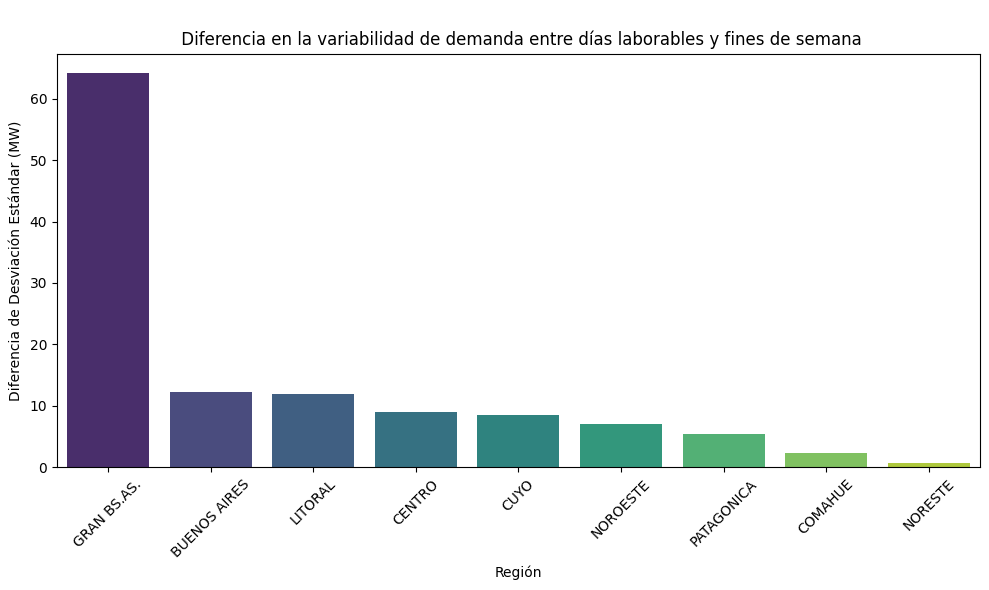

In [48]:
# Defino tipo de dia simple
df_final['TIPO_DIA_SIMPLE'] = df_final['TIPO DIA'].apply(lambda x: 'Finde' if x in ['Sabado o Semilaborable', 'Domingo o Feriado'] else 'Laborable')

# Dividir el dataframe según tipo de día
df_laborable = df_final[df_final['TIPO_DIA_SIMPLE'] == 'Laborable']
df_finde = df_final[df_final['TIPO_DIA_SIMPLE'] == 'Finde']

# Calcular la desviación estándar de cada grupo
std_laborable = df_laborable[columnas_regiones].std()
std_finde = df_finde[columnas_regiones].std()

variabilidad = pd.DataFrame({
    'Desv_Laborable': std_laborable,
    'Desv_Finde': std_finde
})
variabilidad['DIFERENCIA'] = abs(variabilidad['Desv_Laborable'] - variabilidad['Desv_Finde'])

# Ordenar por mayor diferencia
variabilidad_ordenada = variabilidad.sort_values(by='DIFERENCIA', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(x=variabilidad_ordenada.index, y='DIFERENCIA', hue=variabilidad_ordenada.index, data=variabilidad_ordenada, palette='viridis', legend=False)
plt.xticks(rotation=45)
plt.title('\n Diferencia en la variabilidad de demanda entre días laborables y fines de semana')
plt.ylabel('Diferencia de Desviación Estándar (MW)')
plt.xlabel('Región')
plt.tight_layout()
display(variabilidad_ordenada)
plt.show()

El análisis de la desviación estándar evidencia que la región del Gran Buenos Aires presenta la mayor diferencia de variabilidad entre días laborables y fines de semana, superando ampliamente al resto de las regiones. Este comportamiento sugiere una fuerte influencia del componente industrial y comercial en la estructura de demanda semanal. En contraste, regiones como Noreste y Comahue muestran perfiles más estables, con menor sensibilidad al calendario.